# Experiments on sparse CapsNet inference

from `Capsule Networks as Generative Models': https://arxiv.org/abs/2209.02567

In [74]:
import sys
!{sys.executable} -m pip install torch torchvision

## Network

Credit where due: main CapsNet classes and training routine adapted from https://github.com/adambielski/CapsNet-pytorch

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import numpy as np
import time
import os
import glob
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms


In [157]:
def conv_output_dim(input_dim, kernel_size, stride):
    return ((input_dim - (kernel_size - 1) - 1) // stride) + 1


def conv_output_dims(input_dims, kernel_size, stride):
    x, y = input_dims
    out_x = conv_output_dim(x, kernel_size, stride)
    out_y = conv_output_dim(y, kernel_size, stride)
    return out_x, out_y


def squash(x):
    lengths2 = x.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
    return x


def one_hots(ints, lengths):
    t = torch.zeros(lengths.size()).long()
    if ints.is_cuda:
        t = t.cuda()
    return t.scatter_(1, ints.data.view(-1, 1), 1)


def standard_pc_error(e,_):
    return torch.sum(torch.square(e))


def pc_plus_capsules_l1(e,x, penalty=1):
    capsule_magnitudes = x.pow(2).sum(dim=2).sqrt()
    return standard_pc_error(e, x) + penalty*torch.sum(capsule_magnitudes)


class AgreementRouting(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(AgreementRouting, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()
        
        if self.n_iterations == 0:
            return squash(u_predict.sum(dim=1))

        c = F.softmax(self.b)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        if self.n_iterations > 1:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
                s = (c * u_predict).sum(dim=1)
                v = squash(s)

        return v


class CapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(CapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)

        v = self.routing_module(u_predict)
        return v


class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out


class CapsNet(nn.Module):
    def __init__(self, routing_iterations, n_classes=10):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primaryCaps = PrimaryCapsLayer(256, 32, 8, kernel_size=9, stride=2)  # outputs 6*6
        self.num_primaryCaps = 32 * 6 * 6
        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, 8, n_classes, 16, routing_module)
        self.n_classes = n_classes
        
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs

    
class ReconstructionNet(nn.Module):
    def __init__(self, n_dim=16, n_classes=10):
        super(ReconstructionNet, self).__init__()
        self.fc1 = nn.Linear(n_dim * n_classes, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)
        self.n_dim = n_dim
        self.n_classes = n_classes

    def forward(self, x, target):
        mask = Variable(torch.zeros((x.size()[0], self.n_classes)), requires_grad=False)
        if next(self.parameters()).is_cuda:
            mask = mask.cuda()
        mask.scatter_(1, target.view(-1, 1), 1.)
        mask = mask.unsqueeze(2)
        x = x * mask
        x = x.view(-1, self.n_dim * self.n_classes)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


class CapsNetWithReconstruction(nn.Module):
    def __init__(self, capsnet, reconstruction_net):
        super(CapsNetWithReconstruction, self).__init__()
        self.capsnet = capsnet
        self.n_classes = self.capsnet.n_classes
        self.reconstruction_net = reconstruction_net

    def forward(self, x, target):
        x, probs = self.capsnet(x)
        reconstruction = self.reconstruction_net(x, target)
        return x, reconstruction, probs


class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets, size_average=True):
        t = torch.zeros(lengths.size()).long()
        if targets.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = Variable(t)
        losses = targets.float() * F.relu(self.m_pos - lengths).pow(2) + \
                 self.lambda_ * (1. - targets.float()) * F.relu(lengths - self.m_neg).pow(2)
        return losses.mean() if size_average else losses.sum()


In [107]:
class PCCapsNet(nn.Module):
    def __init__(
        self, 
        routing_iterations,
        input_dims=(28, 28),
        n_classes=10, 
        conv1_kernel_size=9, 
        conv1_stride=1, 
        num_conv1_channels=256,
        primaryCaps_kernel_size=9, 
        primaryCaps_channels=32,
        primaryCaps_stride=2,
        primaryCaps_dim=8,
        digitCaps_dim=16,
    ):
        super(PCCapsNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, num_conv1_channels, kernel_size=conv1_kernel_size, stride=conv1_stride)
        self.primaryCaps = PrimaryCapsLayer(num_conv1_channels, primaryCaps_channels, primaryCaps_dim, kernel_size=primaryCaps_kernel_size, stride=primaryCaps_stride)  # outputs 6*6

        conv1_out_x, conv1_out_y = conv_output_dims(input_dims, conv1_kernel_size, conv1_stride)
        primaryCaps_out_x, primaryCaps_out_y = conv_output_dims((conv1_out_x, conv1_out_y), primaryCaps_kernel_size, primaryCaps_stride)

        self.num_primaryCaps = primaryCaps_channels * primaryCaps_out_x * primaryCaps_out_y

        routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
        self.digitCaps = CapsLayer(self.num_primaryCaps, primaryCaps_dim, n_classes, digitCaps_dim, routing_module)

    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs

    def infer(self, x, targets, num_steps=500, lr=1e-2, momentum=0., loss_fn=standard_pc_error):
        model.eval()
        for param in self.parameters():
            param.requires_grad = False

        conv1_out = self.conv1(x).float()
        primaryCaps_out = self.primaryCaps(conv1_out).float()
        digitCaps_out = self.digitCaps(primaryCaps_out).float()
        probs = digitCaps_out.pow(2).sum(dim=2).sqrt()

        conv1_x = nn.Parameter(conv1_out)
        primaryCaps_x = nn.Parameter(primaryCaps_out)
        digitCaps_x = nn.Parameter(digitCaps_out)

        # One-hot encode target
        t = torch.zeros(torch.Size([targets.size()[0], self.n_classes])).long()
        if targets.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = Variable(t)

        activations = []
        l2_norms = []
        losses = []
        
        opt = optim.SGD([conv1_x, primaryCaps_x, digitCaps_x], lr=lr, momentum=momentum)
        opt.zero_grad()
        
        for step in range(num_steps):
            opt.zero_grad()

            conv1_errors = conv1_x - self.conv1(x)            
            primaryCaps_errors = primaryCaps_x - self.primaryCaps(conv1_x)
            digitCaps_errors = digitCaps_x - self.digitCaps(primaryCaps_x)            
            output_errors = digitCaps_x.pow(2).sum(dim=2).sqrt() - targets
                        
            loss = loss_fn(conv1_errors, digitCaps_x) \
                + loss_fn(primaryCaps_errors, digitCaps_x) \
                + loss_fn(digitCaps_errors, digitCaps_x) \
                + loss_fn(output_errors, digitCaps_x)            
            if step%100==0:
                print("loss", loss)

            loss.backward()            
            opt.step()

            activations.append(digitCaps_out.detach().cpu().numpy())
            l2_norms.append(probs.detach().cpu().numpy())
            losses.append(loss.detach().cpu().numpy())

        for param in self.parameters():
            param.requires_grad = True

        return activations, l2_norms, losses

    
class PCCapsNetWithReconstruction(nn.Module):
    def __init__(self, pccapsnet, reconstruction_net):
        super(PCCapsNetWithReconstruction, self).__init__()
        self.pccapsnet = pccapsnet
        self.n_classes = self.pccapsnet.n_classes
        self.reconstruction_net = reconstruction_net

    def forward(self, x, target):
        x, probs = self.pccapsnet(x)
        reconstruction = self.reconstruction_net(x, target)
        return x, reconstruction, probs


# Two-layer version of CapsNet (reduce PrimaryCaps to 16 channels and add a SecondaryCaps of same shape)
class CapsNet2(nn.Module):
    def __init__(
        self, 
        routing_iterations,
        input_dims=(28, 28),
        n_classes=10, 
        conv1_kernel_size=9, 
        conv1_stride=1, 
        num_conv1_channels=256,
        primaryCaps_kernel_size=9, 
        primaryCaps_channels=16,
        primaryCaps_stride=2,
        primaryCaps_dim=8,
        secondaryCaps_channels=16,
        secondaryCaps_dim=8,
        digitCaps_dim=16,
    ):
        super(CapsNet2, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, num_conv1_channels, kernel_size=conv1_kernel_size, stride=conv1_stride)
        self.primaryCaps = PrimaryCapsLayer(num_conv1_channels, primaryCaps_channels, primaryCaps_dim, kernel_size=primaryCaps_kernel_size, stride=primaryCaps_stride)  # outputs 6*6

        conv1_out_x, conv1_out_y = conv_output_dims(input_dims, conv1_kernel_size, conv1_stride)
        primaryCaps_out_x, primaryCaps_out_y = conv_output_dims((conv1_out_x, conv1_out_y), primaryCaps_kernel_size, primaryCaps_stride)
        print("PCx", primaryCaps_out_x, "PCy", primaryCaps_out_y)
        self.num_primaryCaps = primaryCaps_channels * primaryCaps_out_x * primaryCaps_out_y

        routing_module_1 = AgreementRouting(self.num_primaryCaps, secondaryCaps_channels, routing_iterations)
        self.secondaryCaps = CapsLayer(self.num_primaryCaps, primaryCaps_dim, secondaryCaps_channels, secondaryCaps_dim, routing_module_1)
                
        routing_module_2 = AgreementRouting(secondaryCaps_channels, n_classes, routing_iterations)        
        self.digitCaps = CapsLayer(secondaryCaps_channels, secondaryCaps_dim, n_classes, digitCaps_dim, routing_module_2)


    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.secondaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs
    
    
class CapsNet2WithReconstruction(nn.Module):
    def __init__(self, capsnet2, reconstruction_net):
        super(CapsNet2WithReconstruction, self).__init__()
        self.capsnet2 = capsnet2
        self.n_classes = self.capsnet2.n_classes
        self.reconstruction_net = reconstruction_net

    def forward(self, x, target):
        x, probs = self.capsnet2(x)
        reconstruction = self.reconstruction_net(x, target)
        return x, reconstruction, probs

# Training setup

In [118]:
batch_size = 128
test_batch_size = 1000
trial_batch_size = 10
epochs = 13
lr = 0.001
cuda = True and torch.cuda.is_available()
with_reconstruction = True
seed = 33
log_interval = 10
routing_iterations = 0
model_type = "standard"


assert model_type in ["standard", "two-layer"], "Please choose `standard` or `two-layer` model type!"

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2), transforms.RandomCrop(28),
                        transforms.ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

inference_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2), transforms.RandomCrop(28),
                        transforms.ToTensor()
                    ])),
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])),
    batch_size=test_batch_size, shuffle=False, **kwargs)

if model_type == "standard":
    model = CapsNet(routing_iterations)
elif model_type == "two-layer":
    model = CapsNet2(routing_iterations)

reconstruction_alpha = 0.0005
if with_reconstruction:
    reconstruction_model = ReconstructionNet(16, 10)
    if model_type=="standard":
        model = CapsNetWithReconstruction(model, reconstruction_model)
    else:
        model = CapsNet2WithReconstruction(model, reconstruction_model)

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=15, min_lr=1e-6)

loss_fn = MarginLoss(0.9, 0.1, 0.5)


def train(epoch, with_recon=True):
    model.train()

    outputs, probabilities, losses = [], [], {"total": []}
    if with_reconstruction:
        losses["recon"], losses["margin"] = [], []

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()

        if with_recon:
            output, recon, probs = model(data, target)
            if cuda:
                outputs.append(output.detach().cpu().numpy())
                probabilities.append(probs.detach().cpu().numpy())

            else:
                outputs.append(output.detach().numpy())
                probabilities.append(probs.detach().numpy())

            reconstruction_loss = F.mse_loss(recon, data.view(-1, 784))
            margin_loss = loss_fn(probs, target)
            if cuda:
                losses["recon"].append(reconstruction_loss.detach().cpu().numpy())
                losses["margin"].append(margin_loss.detach().cpu().numpy())
            else:
                losses["recon"].append(reconstruction_loss.detach().numpy())
                losses["margin"].append(margin_loss.detach().numpy())
            loss = reconstruction_alpha * reconstruction_loss + margin_loss

        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
            if cuda:
                outputs.append(output.detach().cpu().numpy())
                probabilities.append(probs.detach().cpu().numpy())
            else:
                outputs.append(output.detach().numpy())
                probabilities.append(probs.detach().numpy())

        if cuda:
            losses["total"].append(loss.detach().cpu().numpy())
        else:
            losses["total"].append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data))

    return losses, outputs, probabilities


def test(with_recon=True):
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            if with_recon:
                _, recon, probs = model(data, target)
                reconstruction_loss = F.mse_loss(recon, data.view(-1, 784), size_average=False).data
                test_loss += loss_fn(probs, target, size_average=False).data
                test_loss += reconstruction_alpha * reconstruction_loss
            else:
                _, probs = model(data)
                test_loss += loss_fn(probs, target, size_average=False).data

            pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return test_loss


PCx 6 PCy 6


# Train

In [119]:
session_number = str(time.time()).split('.')[0]
datapath = f'data/{model_type}_recon{with_reconstruction}_iters{routing_iterations}_session{session_number}'
os.makedirs(datapath)


train_losses = []
test_losses = []
if with_reconstruction:
    margin_losses = []
    recon_losses = []

start = time.time()
for epoch in range(1, epochs + 1):
    train_loss, outputs, probabilities = train(epoch, with_reconstruction)
    train_losses.append(train_loss["total"])

    if with_reconstruction:
        margin_losses.append(train_loss["margin"])
        recon_losses.append(train_loss["recon"])

    test_loss = test(with_reconstruction)
    if cuda:
        test_losses.append(test_loss.cpu().numpy())
    else:
        test_losses.append(test_loss.numpy())


    scheduler.step(test_loss)

    torch.save(model.state_dict(),
        '{}/{}_{:03d}_model_dict_{}routing_reconstruction{}.pth'.format(
            datapath, model_type, epoch, routing_iterations, with_reconstruction
        )
    )

    np.save(f'{datapath}/{model_type}_{epoch:03d}_train_losses', train_losses)
    np.save(f'{datapath}/{model_type}_{epoch:03d}_test_losses', test_losses)

    np.save(f'{datapath}/{model_type}_{epoch:03d}_outputs', outputs)
    np.save(f'{datapath}/{model_type}_{epoch:03d}_probabilities', probabilities)

    if with_reconstruction:
        np.save(f'{datapath}/{model_type}_{epoch:03d}_recon_losses', recon_losses)
        np.save(f'{datapath}/{model_type}_{epoch:03d}_margin_losses', margin_losses)
    
    train_time = time.time() - start
    print("Train time for epoch: ", f"{train_time/60} mins.")
    start = time.time()


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.080185
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.054503
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.052391
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.051459
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.047544
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.041586
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.033197
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.030793
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.026868
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.020400
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.019724
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.015575
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.014983
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.010594
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.010603
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.009469
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.009965
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.010293
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.007007
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.009154
Train Epoch: 1 [

# PC Inference

### Optionally load pretrained model

In [46]:
STANDARD_PATH = 'data/models/standard/final_weights.pth'
STANDARD_NO_RECON_PATH = 'data/models/no_reconstruction/standard/final_weights.pth'
NO_ROUTING_PATH = 'data/models/no_routing/final_weights.pth'
NO_ROUTING_NO_RECON_PATH = 'data/models/no_reconstruction/no_routing/final_weights.pth'

NRNRP = 'data/standard_reconFalse_iters0_session_13epochs/standard_013_model_dict_0routing_reconstructionFalse.pth'
SNRP = 'data/standard_reconFalse_iters3_session_13epochs/standard_012_model_dict_3routing_reconstructionFalse.pth'

def load_model(with_routing=True, with_reconstruction=True):
    if with_routing:
        if with_reconstruction:
            print("Loading standard CapsNet...")
            model = CapsNet(routing_iterations=3)
            reconstruction_model = ReconstructionNet(16, 10)
            model = CapsNetWithReconstruction(model, reconstruction_model)
            path = STANDARD_PATH
            reconstruction_alpha = 0.0005
        else:            
            print("Loading standard CapsNet with no reconstruction...")
            model = CapsNet(routing_iterations=3)
            path = STANDARD_NO_RECON_PATH
    else:
        if with_reconstruction:
            model = CapsNet(routing_iterations=0)
            reconstruction_model = ReconstructionNet(16, 10)
            model = CapsNetWithReconstruction(model, reconstruction_model)
            print("Loading CapsNet without routing...")
            path = NO_ROUTING_PATH
            reconstruction_alpha = 0.0005
        else:
            model = PCCapsNet(routing_iterations=0)
            print("Loading CapsNet without routing or reconstruction...")
            path = NO_ROUTING_NO_RECON_PATH

    if cuda:
        model.cuda()
    model.load_state_dict(torch.load(path))

    return model
    

In [239]:
def get_digit_caps(model, image, with_reconstruction=True):
    if with_reconstruction:
        model = model.capsnet
    with torch.no_grad():
        input_ = Variable(image.unsqueeze(0))
        digit_caps, probs = model(input_)
        return digit_caps, probs


def plot_caps_activations(data, epoch, num_datapoints=10, ymin=-0.5, ymax=0.5):
    outputs = []
    for batch in data[:num_datapoints]:
        print(batch[0].shape)
        fig, axes = plt.subplots(1, 10)
        for idx, ax in enumerate(axes):
            ax.bar(range(16), batch[idx][0])
            ax.set_ylim([ymin, ymax])
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.set_xlabel(idx)
            if idx > 0:
                ax.yaxis.set_ticklabels([])
        plt.show()

        
def plot_caps_activations_single(digitcaps, ymin=-0.5, ymax=0.5):
    fig, axes = plt.subplots(1, 10)
    for idx, ax in enumerate(axes):
        ax.bar(range(16), digitcaps[0][idx])
        ax.set_ylim([ymin, ymax])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.set_xlabel(idx)
        if idx > 0:
            ax.yaxis.set_ticklabels([])
    plt.show()
        

def get_n_examples(n=5, loader=inference_loader):
    images, labels = [], []
    for i in range(n):
        image_tensor, label = next(iter(inference_loader))
        images.append(image_tensor)
        labels.append(label)
    return {"images": images, "labels": labels}


def infer_one_example(x, targets, model=model, num_steps=500, lr=1e-2, momentum=0., loss_fn=standard_pc_error, with_reconstruction=True):
    if with_reconstruction:
        model = model.capsnet
        
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    conv1_out = model.conv1(x).float()
    primaryCaps_out = model.primaryCaps(conv1_out).float()
    digitCaps_out = model.digitCaps(primaryCaps_out).float()
    probs = digitCaps_out.pow(2).sum(dim=2).sqrt()

    input_x = nn.Parameter(x)
    conv1_x = nn.Parameter(conv1_out)
    primaryCaps_x = nn.Parameter(primaryCaps_out)
    digitCaps_x = nn.Parameter(digitCaps_out)

    # One-hot encode target
    t = torch.zeros(torch.Size([targets.size()[0], model.n_classes])).long()
    if targets.is_cuda:
        t = t.cuda()
    t = t.scatter_(1, targets.data.view(-1, 1), 1)
    targets = Variable(t)

    activations = []
    l2_norms = []
    losses = []

    opt = optim.SGD([input_x, conv1_x, primaryCaps_x, digitCaps_x], lr=lr, momentum=momentum)
    opt.zero_grad()

    for step in range(num_steps):
        opt.zero_grad()

        x_errors = input_x - x
        conv1_errors = conv1_x - model.conv1(x)            
        primaryCaps_errors = primaryCaps_x - model.primaryCaps(conv1_x)
        # primaryCaps_errors = primaryCaps_x - primaryCaps_out
        digitCaps_errors = digitCaps_x - model.digitCaps(primaryCaps_x)
        probs = digitCaps_x.pow(2).sum(dim=2).sqrt()
        output_errors = probs - targets

        loss = loss_fn(output_errors, digitCaps_x) \
            + standard_pc_error(digitCaps_errors, _) \
            + standard_pc_error(primaryCaps_errors, _) \
            + standard_pc_error(conv1_errors, _) \
            + standard_pc_error(x_errors, _)
        
        # loss = loss_fn(output_errors, digitCaps_x)
        if step%100==0:
            print("loss", loss)

        loss.backward()            
        opt.step()

        activations.append(digitCaps_out.detach().cpu().numpy())
        l2_norms.append(probs.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    for param in model.parameters():
        param.requires_grad = True

    return digitCaps_x.detach().cpu().numpy(), probs


def add_labels(plot, x,y, upper=False):
    for i in range(len(x)):
        e = 13.3
        if not upper:
            e = np.Inf
        plot.text(i, min(e,int(y[i]) + 1.1), int(y[i]), ha = 'center')
        
        
def plot_results(num_examples=5, model_type="routing", loader=inference_loader, recon=True, data=None, lr=1e-2, num_steps=500):

    assert model_type in ["routing", "no_routing", "iterative", "iterative_l1"]
    
    if model_type == "routing":
        if recon:
            model = load_model()
        else:
            model = load_model(with_reconstruction=False)
    else:
        if recon:
            model = load_model(with_routing=False)
        else:
            model = load_model(with_routing=False, with_reconstruction=False)    
    model.eval()
    
    images = []
    if data is not None:
        images = [data["images"][i].numpy()[0][0] for i in range(num_examples)]

    ymin, ymax = -0.5, 0.5

    for i in range(num_examples):
        if data is not None:
            image_tensor, label = data["images"][i], data["labels"][i]
        else:
            image_tensor, label = next(iter(loader))
            images.append(image_tensor.numpy()[0][0])
        if cuda:
            image_tensor, label = image_tensor.cuda(), label.cuda()
        image_tensor, label = Variable(image_tensor), Variable(label)
        
        fig, axs = plt.subplots(1, 11, figsize=(8, 1))
        ax = axs[0]
        ax.imshow(images[i], cmap='gray')
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks([])

        print(image_tensor.shape)
        if model_type in ["routing", "no_routing"]:
            digit_caps, probs = get_digit_caps(model, image_tensor[0], with_reconstruction=recon)
            digit_caps = digit_caps.detach().cpu().numpy()
            probs = probs.detach().cpu().numpy()
        elif model_type == "iterative":
            digit_caps, probs = infer_one_example(image_tensor, label, model, with_reconstruction=recon, num_steps=num_steps, lr=lr)
            probs = probs.detach().cpu().numpy()
        elif model_type == "iterative_l1":
            digit_caps, probs = infer_one_example(image_tensor, label, model, loss_fn=pc_plus_capsules_l1, with_reconstruction=recon, num_steps=num_steps, lr=lr)
            probs = probs.detach().cpu().numpy()
        print(digit_caps.shape)
                
        for idx in range(1, 11):
            ax = axs[idx]
            if idx-1 == label:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
            ax.bar(range(16), digit_caps[0][idx-1])
            ax.set_ylim([ymin, ymax])
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.set_xlabel(idx-1)
            ax.title.set_text(round(probs[0][idx-1], 2))
            
            if idx < 10:
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticks([])
            else:
                ax.yaxis.tick_right()

    plt.savefig(f"samples/caps_{model_type}_{time.time()}.png")
    plt.show()


3-routing model:
Loading standard CapsNet...
torch.Size([1, 1, 28, 28])
(1, 10, 16)


/tmp/ipykernel_51/616523331.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/tmp/ipykernel_51/616523331.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)


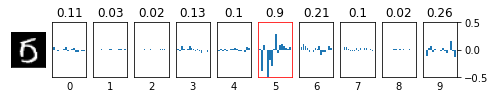

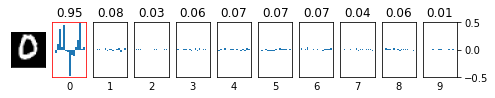

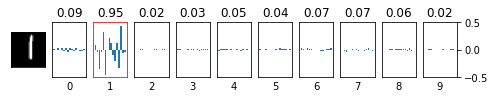

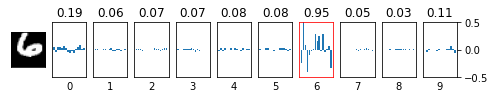

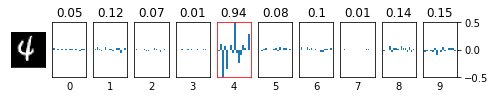

0-routing model:
Loading CapsNet without routing...
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)
torch.Size([1, 1, 28, 28])
(1, 10, 16)


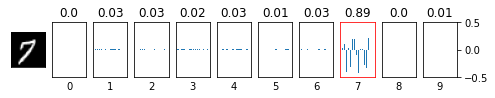

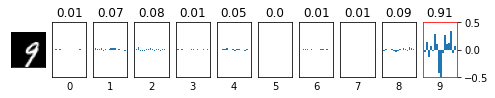

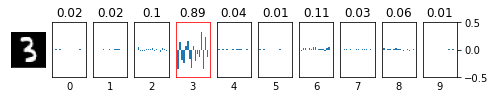

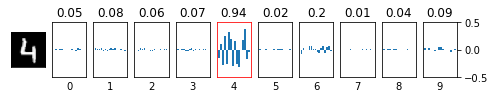

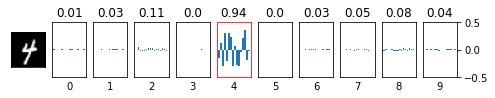

iterative model:
Loading CapsNet without routing...
torch.Size([1, 1, 28, 28])
loss tensor(7.7689, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.6949, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.6521, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.6470, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.6460, device='cuda:0', grad_fn=<AddBackward0>)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(8.0664, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.8371, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.7930, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.7892, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(3.7887, device='cuda:0', grad_fn=<AddBackward0>)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(8.4743, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(4.1242, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(4.0910, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(4.0847, device='cuda:0', grad_fn=<AddB

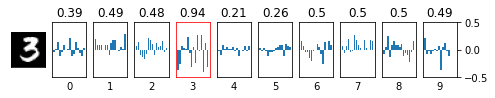

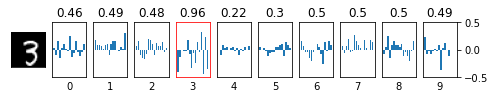

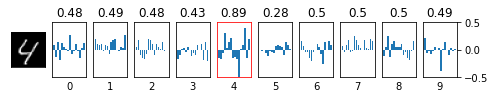

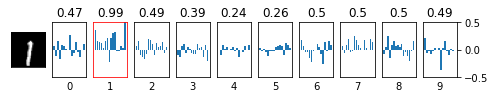

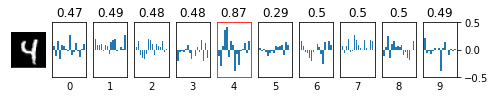

iterative model plus L1:
Loading CapsNet without routing...
torch.Size([1, 1, 28, 28])
loss tensor(16.8681, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.1742, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.1150, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.1072, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.1064, device='cuda:0', grad_fn=<AddBackward0>)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(17.8091, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.8475, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.7713, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.6807, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.6477, device='cuda:0', grad_fn=<AddBackward0>)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(16.7539, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(7.0574, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(6.9981, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(6.9882, device='cuda:0', gr

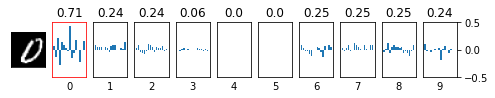

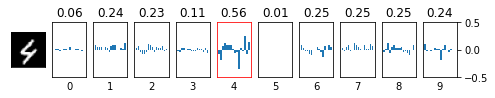

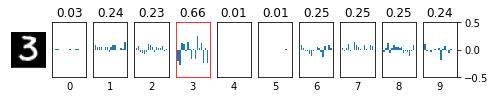

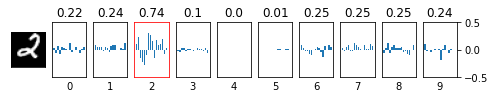

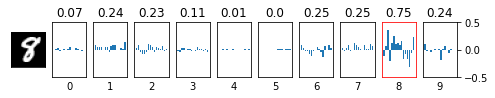

In [238]:
print("3-routing model:")
plot_results(model_type="routing")

print("0-routing model:")
plot_results(model_type="no_routing")

print("iterative model:")
plot_results(model_type="iterative")

print("iterative model plus L1:")
plot_results(model_type="iterative_l1")



## 2-layer CapsNet experiments

In [70]:
def get_caps_activities(model, image, with_reconstruction=False):
    if with_reconstruction:
        model = model.capsnet2
    with torch.no_grad():
        input_ = Variable(image.unsqueeze(0))
        x = model.conv1(input_)
        x = F.relu(x)
        pc = model.primaryCaps(x)
        sc = model.secondaryCaps(pc)
        dc = model.digitCaps(sc)
        probs = dc.pow(2).sum(dim=2).sqrt()

        return pc, sc, dc, probs

        
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.primaryCaps(x)
        x = self.secondaryCaps(x)
        x = self.digitCaps(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs


### Load models

In [120]:
TWOLAYER_PATH = 'data/two-layer_reconFalse_iters3_session1656238156/two-layer_013_model_dict_3routing_reconstructionFalse.pth'
TWOLAYER_NO_ROUTING_PATH = 'data/two-layer_reconTrue_iters0_session1656255718/two-layer_013_model_dict_0routing_reconstructionTrue.pth'

TWOLAYER_10ROUTING_PATH = 'data/two-layer_reconFalse_iters10_session1656253762/two-layer_012_model_dict_10routing_reconstructionFalse.pth'

TWOLAYER_WITH_RECON_PATH = 'data/two-layer_reconTrue_iters3_session1656254683/two-layer_013_model_dict_3routing_reconstructionTrue.pth'


def load_model2(with_routing=True, with_reconstruction=True):
    if with_routing:
        if with_reconstruction:
            print("Loading CapsNet2...")
            model = CapsNet2(routing_iterations=3)
            reconstruction_model = ReconstructionNet(16, 10)
            model = CapsNet2WithReconstruction(model, reconstruction_model)
            path = TWOLAYER_WITH_RECON_PATH
            reconstruction_alpha = 0.0005
        else:            
            print("Loading CapsNet2 with no reconstruction...")
            model = CapsNet2(routing_iterations=3)
            path = TWOLAYER_10ROUTING_PATH
    else:
        if with_reconstruction:
            model = CapsNet2(routing_iterations=0)
            reconstruction_model = ReconstructionNet(16, 10)
            model = CapsNet2WithReconstruction(model, reconstruction_model)
            print("Loading CapsNet without routing...")
            path = TWOLAYER_NO_ROUTING_PATH
            reconstruction_alpha = 0.0005
        else:
            model = CapsNet2(routing_iterations=0)
            print("Loading CapsNet without routing or reconstruction...")
            path = TWOLAYER_NO_ROUTING_PATH

    if cuda:
        model.cuda()
    model.load_state_dict(torch.load(path))

    return model


### Iterative inference

In [180]:
def infer_one_example_twolayer(x, targets, model=model, num_steps=500, lr=1e-2, momentum=0., loss_fn=standard_pc_error, with_reconstruction=True, penalty=1):
    if with_reconstruction:
        model = model.capsnet2
        
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    conv1_out = model.conv1(x).float()
    primaryCaps_out = model.primaryCaps(conv1_out).float()
    secondaryCaps_out = model.secondaryCaps(primaryCaps_out).float()
    digitCaps_out = model.digitCaps(secondaryCaps_out).float()
    probs = digitCaps_out.pow(2).sum(dim=2).sqrt()

    conv1_x = nn.Parameter(conv1_out)
    primaryCaps_x = nn.Parameter(primaryCaps_out)
    secondaryCaps_x = nn.Parameter(secondaryCaps_out)
    digitCaps_x = nn.Parameter(digitCaps_out)

    # One-hot encode target
    t = torch.zeros(torch.Size([targets.size()[0], model.n_classes])).long()
    if targets.is_cuda:
        t = t.cuda()
    t = t.scatter_(1, targets.data.view(-1, 1), 1)
    targets = Variable(t)

    pc_activations = []
    sc_activations = []
    dc_activations = []
    l2_norms = []
    losses = []

    opt = optim.SGD([conv1_x, primaryCaps_x, secondaryCaps_x, digitCaps_x], lr=lr, momentum=momentum)
    opt.zero_grad()

    for step in range(num_steps):
        opt.zero_grad()

        conv1_errors = conv1_x - model.conv1(x)            
        primaryCaps_errors = primaryCaps_x - model.primaryCaps(conv1_x)
        secondaryCaps_errors = secondaryCaps_x - model.secondaryCaps(primaryCaps_x)
        digitCaps_errors = digitCaps_x - model.digitCaps(secondaryCaps_x)            
        output_errors = digitCaps_x.pow(2).sum(dim=2).sqrt() - targets

        loss = standard_pc_error(conv1_errors, digitCaps_x) \
            + standard_pc_error(primaryCaps_errors, digitCaps_x) \
            + loss_fn(secondaryCaps_errors, secondaryCaps_x, penalty=-5) \
            + standard_pc_error(digitCaps_errors, digitCaps_x) \
            + loss_fn(output_errors, digitCaps_x)  
        
        # loss = loss_fn(output_errors, digitCaps_x)
        if step%100==0:
            print("loss", loss)

        loss.backward()            
        opt.step()

        pc_activations.append(primaryCaps_out.detach().cpu().numpy())
        sc_activations.append(secondaryCaps_out.detach().cpu().numpy())
        dc_activations.append(digitCaps_out.detach().cpu().numpy())
        l2_norms.append(probs.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    for param in model.parameters():
        param.requires_grad = True

    return secondaryCaps_out.detach().cpu().numpy(), digitCaps_x.detach().cpu().numpy()

### Plotting

In [181]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

# fig = plt.figure(constrained_layout=True)

# gs = GridSpec(3, 3, figure=fig)
# ax1 = fig.add_subplot(gs[0, :])
# # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
# ax2 = fig.add_subplot(gs[1, :-1])
# ax3 = fig.add_subplot(gs[1:, -1])
# ax4 = fig.add_subplot(gs[-1, 0])
# ax5 = fig.add_subplot(gs[-1, -2])

# fig.suptitle("GridSpec")
# format_axes(fig)

# plt.show()


def plot_results2(num_examples=5, model_type="routing", loader=inference_loader, recon=False, data=None):

    assert model_type in ["routing", "no_routing", "iterative", "iterative_l1"]
    
    if model_type == "routing":
        if recon:
            model = load_model2(with_reconstruction=True)
        else:
            model = load_model2(with_reconstruction=False)
    else:
        if recon:
            model = load_model2(with_routing=False, with_reconstruction=True)
        else:
            model = load_model2(with_routing=False, with_reconstruction=False)    
    model.eval()
    
    images = []
    if data is not None:
        images = [data["images"][i].numpy()[0][0] for i in range(num_examples)]

    ymin, ymax = -0.5, 0.5
    
    l2_ymin, l2_ymax = -2, 2

    for i in range(num_examples):
        if data is not None:
            image_tensor, label = data["images"][i], data["labels"][i]
        else:
            image_tensor, label = next(iter(loader))
            images.append(image_tensor.numpy()[0][0])
        if cuda:
            image_tensor, label = image_tensor.cuda(), label.cuda()
        image_tensor, label = Variable(image_tensor), Variable(label)
        
        
        fig = plt.figure(figsize=(16,4))

        gs = GridSpec(2, 16, figure=fig)
        secondary_axs = fig.add_subplot(gs[0, :])
        # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
        #ax2 = fig.add_subplot(gs[1, 0])
        secondary_axs = []
        dc_axs = []
        for idx in range(16):
            secondary_axs.append(fig.add_subplot(gs[1,idx]))
        mnist_ax = fig.add_subplot(gs[0,0])
        mnist_ax.xaxis.set_ticklabels([])
        mnist_ax.xaxis.set_ticks([])
        mnist_ax.yaxis.set_ticklabels([])
        mnist_ax.yaxis.set_ticks([])

        for idx in range(1,11):
            dc_axs.append(fig.add_subplot(gs[0,idx]))
        mnist_ax.imshow(images[i], cmap='gray')

        print(image_tensor.shape)
        if model_type in ["routing", "no_routing"]:
            _, secondary_caps, digit_caps, _ = get_caps_activities(model, image_tensor[0], with_reconstruction=recon)
            secondary_caps = secondary_caps.detach().cpu().numpy()
            digit_caps = digit_caps.detach().cpu().numpy()
        elif model_type == "iterative":
            secondary_caps, digit_caps = infer_one_example_twolayer(image_tensor, label, model, with_reconstruction=recon)
        elif model_type == "iterative_l1":
            secondary_caps, digit_caps = infer_one_example_twolayer(image_tensor, label, model, loss_fn=pc_plus_capsules_l1, with_reconstruction=recon)
        print(secondary_caps.shape)
        print(digit_caps.shape)
                
        for idx in range(0, 10):
            ax = dc_axs[idx]
            if idx == label:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
            ax.bar(range(16), digit_caps[0][idx])
            ax.set_ylim([ymin, ymax])
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.set_xlabel(idx)
            
            if idx < 9:
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticks([])
            else:
                ax.yaxis.tick_right()

        for idx in range(0, 16):
            ax = secondary_axs[idx]
            ax.bar(range(8), secondary_caps[0][idx])
            ax.set_ylim([ymin -.5, ymax + .5])
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.set_xlabel(idx-1)
            
            if idx < 15:
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticks([])
            else:
                ax.yaxis.tick_right()

                
                
    plt.show()



iterative model plus L1:
PCx 6 PCy 6
Loading CapsNet without routing...
torch.Size([1, 1, 28, 28])
loss tensor(-77.1311, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-174.9990, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-176.8355, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-176.8888, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-176.8980, device='cuda:0', grad_fn=<AddBackward0>)
(1, 16, 8)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(-76.9320, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-175.1778, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-177.0068, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-177.0811, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-177.0951, device='cuda:0', grad_fn=<AddBackward0>)
(1, 16, 8)
(1, 10, 16)
torch.Size([1, 1, 28, 28])
loss tensor(-76.6226, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-175.1769, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(-177.0342, device='cuda:

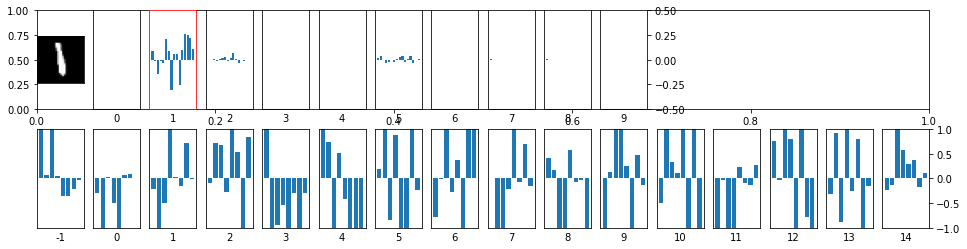

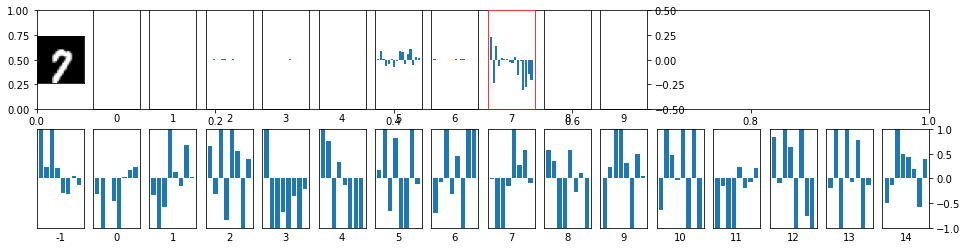

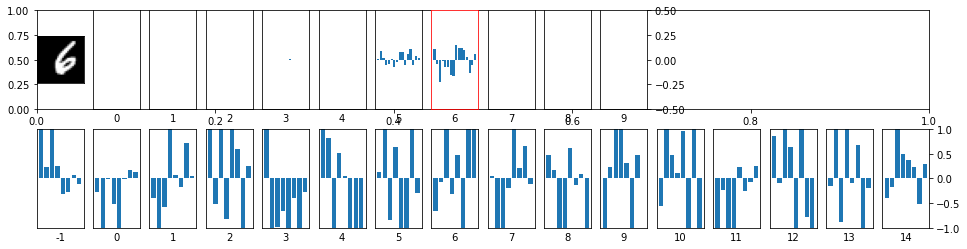

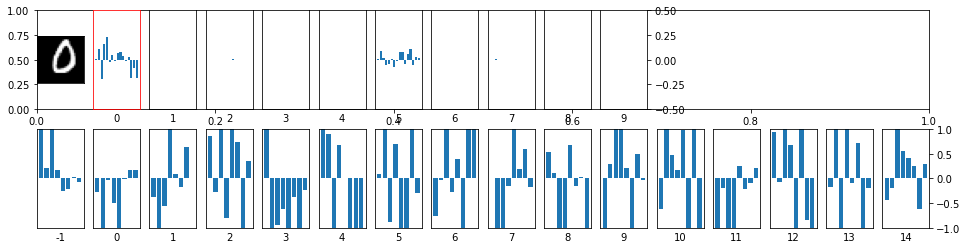

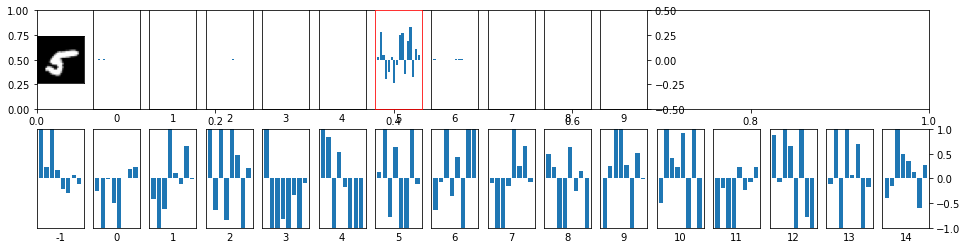

In [182]:
# print("3-routing model:")
# plot_results2(model_type="routing", recon=True)

# print("0-routing model:")
# plot_results2(model_type="no_routing", recon=True)

# print("iterative model:")
# plot_results2(model_type="iterative", recon=True)

print("iterative model plus L1:")
plot_results2(model_type="iterative_l1", recon=True)



# Plot data

In [16]:
def load_data(path):
    files = glob.glob(path + f'/standard_{str(epoch).zfill(3)}*.npy')
    outputs_fn = [fn for fn in files if "output" in fn][0]
    output_data = np.load(outputs_fn, allow_pickle=True)
    print(output_data.shape)

    return output_data


def plot_caps_activations(data, epoch, num_datapoints=10, ymin=-0.5, ymax=0.5):
    outputs = []
    for batch in data[:num_datapoints]:
        print(batch[0].shape)
        fig, axes = plt.subplots(1, 10)
        for idx, ax in enumerate(axes):
            ax.bar(range(16), batch[idx][0])
            ax.set_ylim([ymin, ymax])
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_ticks([])
            ax.set_xlabel(idx)
            if idx > 0:
                ax.yaxis.set_ticklabels([])
        plt.show()


def compare_loss_data(A_path, B_path, log=False, data_type="Test"):
    data_A = np.load(A_path, allow_pickle=True)
    data_B = np.load(B_path, allow_pickle=True)

    start_idx = 0

    if log:

        f = np.log
    else:
        f = lambda x: x
    
    if data_type == "Training":
        g = np.mean
    else:
        g = lambda x: x
        
    data_A = [f(g(a)) for a in data_A]
    data_B = [f(g(b)) for b in data_B]

    plt.plot(range(1, len(data_A[start_idx:]) + 1), data_A[start_idx:], label="CapsNet with 3 routing iterations")
    plt.plot(range(1, len(data_B[start_idx:]) + 1), data_B[start_idx:], label="CapsNet without routing")
    plt.title(f'{data_type} loss per epoch {"(log scale)"*log}')
    plt.xlabel("Epoch")
    plt.ylabel(f"{data_type} set loss")

    plt.legend()
    plt.show()
    plt.clf()


## Plot losses

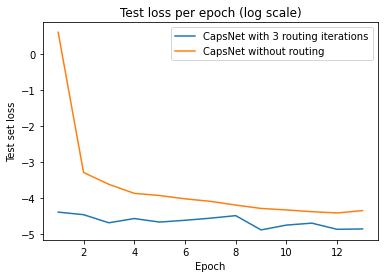

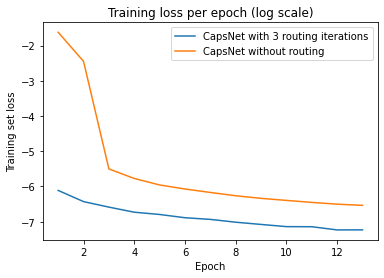

<Figure size 432x288 with 0 Axes>

In [19]:
routing_loss_path = 'data/standard_reconFalse_iters3_session_13epochs/standard_013_test_losses.npy'
no_routing_loss_path = 'data/standard_reconFalse_iters0_session_13epochs/standard_013_test_losses.npy'

rout_train_loss = 'data/standard_reconFalse_iters3_session_13epochs/standard_013_train_losses.npy'
norout_train_loss = 'data/standard_reconFalse_iters0_session_13epochs/standard_013_train_losses.npy'

compare_loss_data(routing_loss_path, no_routing_loss_path, log=True, data_type="Test")
compare_loss_data(rout_train_loss, norout_train_loss, log=True, data_type="Training")

## Test

([<matplotlib.axis.XTick at 0x7f9a3c79f400>,
 [Text(0, 0, 'Standard'),
  Text(1, 0, 'No routing'),
  Text(2, 0, 'No reconstruction'),
  Text(3, 0, 'Neither')])

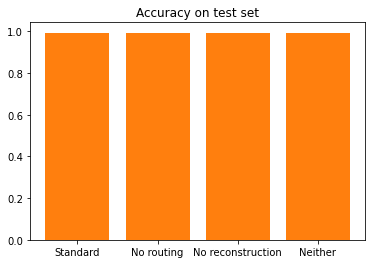

In [52]:
print("Test set loss for +routing +reconstruction model:")
model = load_model()
loss = test()

print("Test set loss for -routing +reconstruction model:")
model = load_model(with_routing=False)
loss_no_routing = test()

print("Test set loss for +routing -reconstruction model:")
model = load_model(with_reconstruction=False)
loss_no_recon = test(with_recon=False)

print("Test set loss for -routing -reconstruction model:")
model = load_model(with_routing=False, with_reconstruction=False)
loss_neither = test(with_recon=False)

plt.bar(range(4), [loss, loss_no_routing, loss_no_recon, loss_neither])
plt.title("Test set loss")
plt.xticks(range(4), ["Standard", "No routing", "No reconstruction", "Neither"])


(469,)
(10, 16)


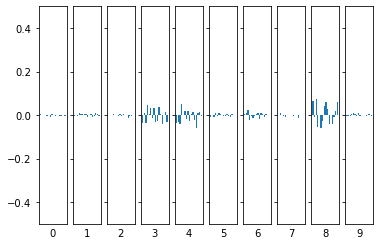

(10, 16)


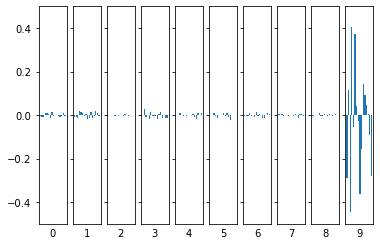

(10, 16)


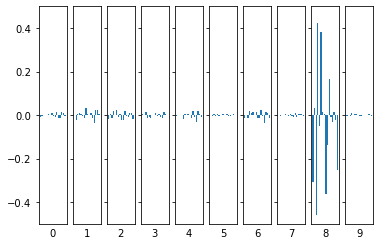

(10, 16)


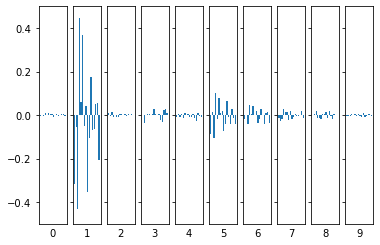

(10, 16)


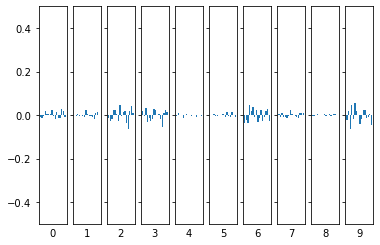

(10, 16)


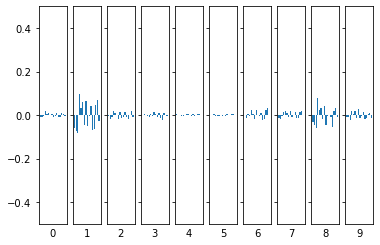

(10, 16)


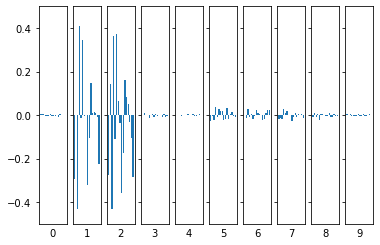

(10, 16)


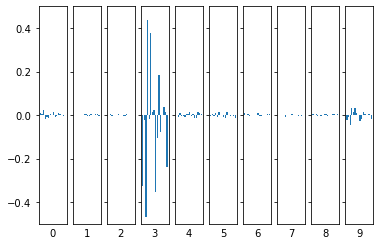

(10, 16)


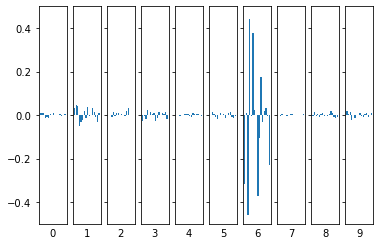

(10, 16)


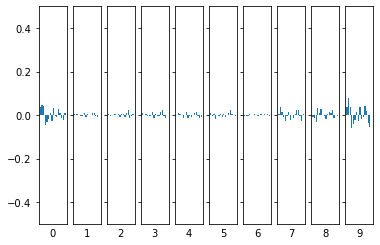

In [152]:
epoch = 13
datapath = 'data/standard_reconFalse_iters3_session_13epochs'

data = load_data(datapath)
plot_caps_activations(data, epoch)



(469,)
(10, 16)


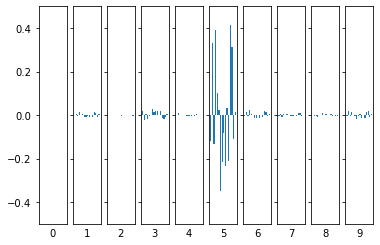

(10, 16)


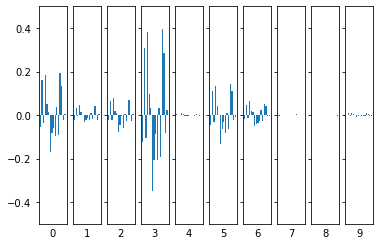

(10, 16)


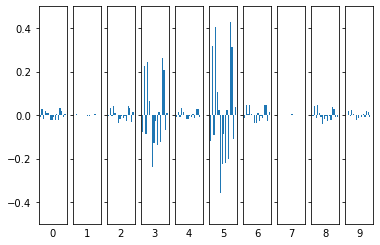

(10, 16)


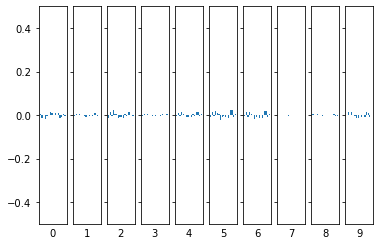

(10, 16)


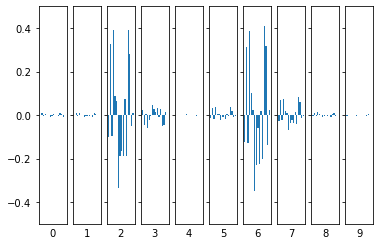

(10, 16)


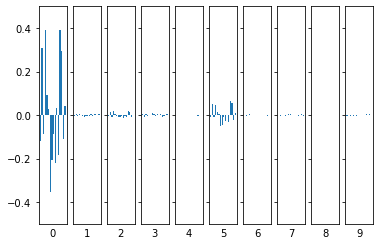

(10, 16)


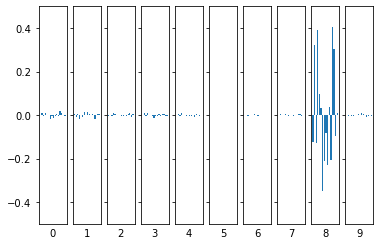

(10, 16)


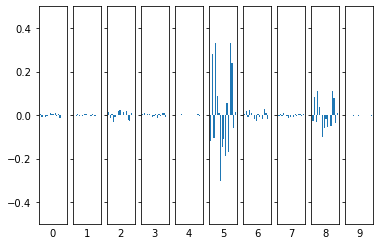

(10, 16)


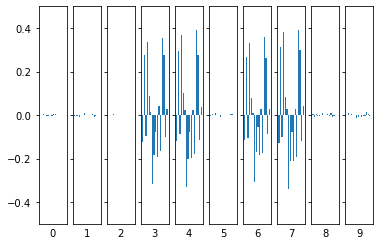

(10, 16)


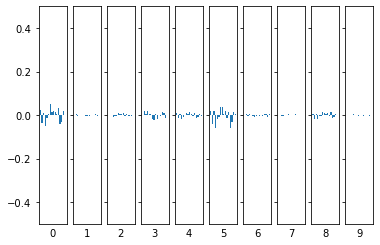

In [9]:
epoch = 13
datapath = 'data/standard_reconFalse_iters0_session_13epochs'

data = load_data(datapath)
plot_caps_activations(data, epoch)

